# Session 3 — Sentence-Level Analysis
## Measure 2: Readability Scores
This notebook computes classic readability formulas for **English** such as:
- Flesch Reading Ease
- Flesch-Kincaid Grade Level

We'll analyze and compare Stephen King's two  books:
- Pet Semetary
- The Shining

In [1]:
import re
from pathlib import Path
import matplotlib.pyplot as plt

# ---------- 1. Load books ----------

def load_book(filepath: str) -> str:
    """
    Load plain-text book from disk and return as a cleaned string.

    Assumes your files are already "raw text" versions (e.g. from a PDF-to-TXT
    conversion), not Project Gutenberg. So we do NOT aggressively strip headers.
    """
    text = Path(filepath).read_text(encoding="utf-8", errors="ignore")

    # Light normalization: normalize newlines and collapse excessive whitespace
    text = text.replace("\r\n", "\n")
    text = re.sub(r"\s+", " ", text)
    return text.strip()


# Paths to your local TXT files
pet_path = "../data/PetSemetary.txt"
sh_path  = "../data/TheShining.txt"

PetSemetary_text = load_book(pet_path)
TheShining_text  = load_book(sh_path)

print(f"Pet Sematary loaded: {len(PetSemetary_text):,} characters")
print(f"The Shining loaded : {len(TheShining_text):,} characters")



Pet Sematary loaded: 796,541 characters
The Shining loaded : 889,483 characters


In [2]:
def count_syllables(word: str) -> int:
    """Simple heuristic syllable counter for English words."""
    word = word.lower()
    # Remove non-alphabetic characters
    word = re.sub(r"[^a-z]", "", word)
    if not word:
        return 1

    # Count vowel groups
    syllables = len(re.findall(r"[aeiouy]+", word))

    # Adjust for silent trailing 'e'
    if word.endswith("e") and syllables > 1:
        syllables -= 1

    # At least one syllable per word
    return max(1, syllables)

In [3]:
def calculate_readability(text: str, book_name: str):
    """Calculate Flesch Reading Ease and Flesch–Kincaid Grade Level."""
    # Split into sentences (very simple heuristic)
    sentences = re.split(r"[.!?]+\s+", text.strip())
    sentences = [s.strip() for s in sentences if s.strip() and len(s.split()) > 2]

    # Extract words (alphabetic + apostrophe, e.g. don't)
    words = re.findall(r"[A-Za-z']+", text)

    num_sentences = len(sentences)
    num_words     = len(words)

    # Guard against division by zero on weird inputs
    if num_sentences == 0 or num_words == 0:
        print(f"\n=== {book_name} ===")
        print("Not enough data to compute readability (0 sentences or 0 words).")
        return None, None

    # Count syllables
    syllables = sum(count_syllables(w) for w in words)

    # Flesch Reading Ease (higher = easier)
    flesch_ease = (
        206.835
        - 1.015 * (num_words / num_sentences)
        - 84.6  * (syllables / num_words)
    )

    # Flesch–Kincaid Grade Level (approx. US school grade)
    flesch_grade = (
        0.39 * (num_words / num_sentences)
        + 11.8 * (syllables / num_words)
        - 15.59
    )

    print(f"\n{'='*70}")
    print(book_name)
    print(f"{'='*70}")
    print(f"Sentences: {num_sentences:,}")
    print(f"Words    : {num_words:,}")
    print(f"Syllables: {syllables:,}")
    print(f"Avg words per sentence : {num_words / num_sentences:.2f}")
    print(f"Avg syllables per word : {syllables / num_words:.2f}")

    print(f"\nFlesch Reading Ease: {flesch_ease:.2f}")
    print("  Interpretation: ", end="")
    if   flesch_ease >= 90:
        print("Very Easy (around 5th grade)")
    elif flesch_ease >= 80:
        print("Easy (around 6th grade)")
    elif flesch_ease >= 70:
        print("Fairly Easy (around 7th grade)")
    elif flesch_ease >= 60:
        print("Standard (around 8th–9th grade)")
    elif flesch_ease >= 50:
        print("Fairly Difficult (around 10th–12th grade)")
    elif flesch_ease >= 30:
        print("Difficult (college level)")
    else:
        print("Very Difficult (college graduate level)")

    print(f"\nFlesch–Kincaid Grade Level: {flesch_grade:.2f}")
    print(f"  Interpretation: suitable for roughly grade {flesch_grade:.0f} and above")

    return flesch_ease, flesch_grade


In [4]:
PetSemetary_ease, PetSemetary_grade = calculate_readability(
    PetSemetary_text, "Pet Sematary"
)
TheShining_ease, TheShining_grade = calculate_readability(
    TheShining_text, "The Shining"
)



Pet Sematary
Sentences: 8,907
Words    : 150,508
Syllables: 198,295
Avg words per sentence : 16.90
Avg syllables per word : 1.32

Flesch Reading Ease: 78.22
  Interpretation: Fairly Easy (around 7th grade)

Flesch–Kincaid Grade Level: 6.55
  Interpretation: suitable for roughly grade 7 and above

The Shining
Sentences: 11,058
Words    : 162,197
Syllables: 218,817
Avg words per sentence : 14.67
Avg syllables per word : 1.35

Flesch Reading Ease: 77.81
  Interpretation: Fairly Easy (around 7th grade)

Flesch–Kincaid Grade Level: 6.05
  Interpretation: suitable for roughly grade 6 and above


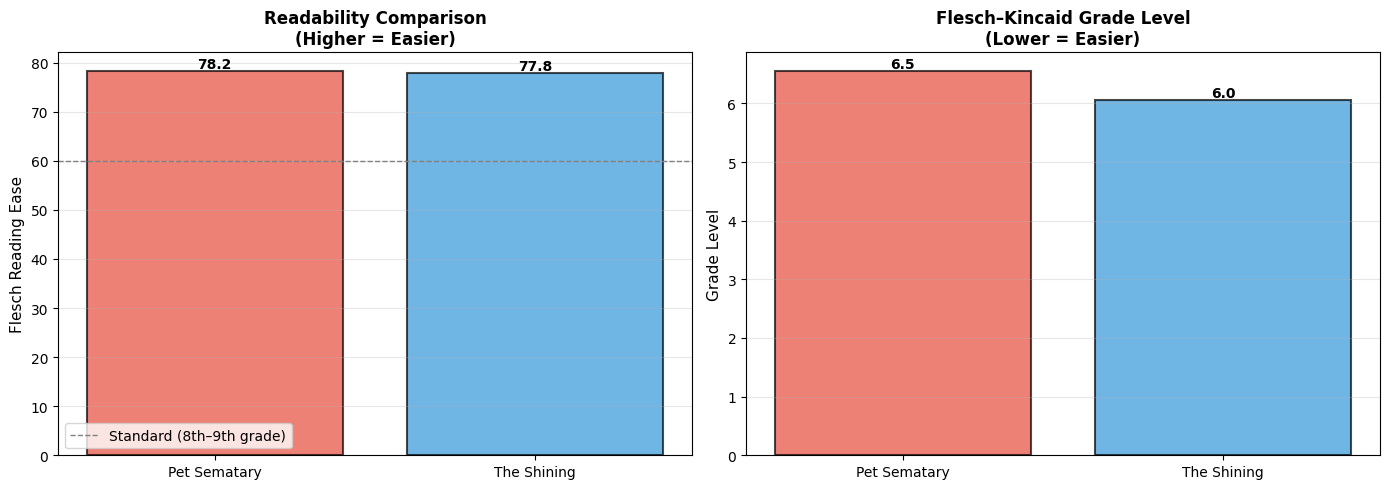

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

books       = ["Pet Sematary", "The Shining"]
ease_scores = [PetSemetary_ease, TheShining_ease]
grade_scores = [PetSemetary_grade, TheShining_grade]
colors      = ["#e74c3c", "#3498db"]

# 5.1 Flesch Reading Ease
ax1 = axes[0]
bars1 = ax1.bar(books, ease_scores, color=colors, edgecolor="black",
                linewidth=1.5, alpha=0.7)
ax1.set_ylabel("Flesch Reading Ease", fontsize=11)
ax1.set_title("Readability Comparison\n(Higher = Easier)", fontsize=12, fontweight="bold")
ax1.axhline(y=60, color="gray", linestyle="--", linewidth=1,
            label="Standard (8th–9th grade)")
ax1.legend()
ax1.grid(True, alpha=0.3, axis="y")

# Value labels
for bar in bars1:
    h = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.0,
        h,
        f"{h:.1f}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

# 5.2 Flesch–Kincaid Grade Level
ax2 = axes[1]
bars2 = ax2.bar(books, grade_scores, color=colors, edgecolor="black",
                linewidth=1.5, alpha=0.7)
ax2.set_ylabel("Grade Level", fontsize=11)
ax2.set_title("Flesch–Kincaid Grade Level\n(Lower = Easier)",
              fontsize=12, fontweight="bold")
ax2.grid(True, alpha=0.3, axis="y")

for bar in bars2:
    h = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2.0,
        h,
        f"{h:.1f}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()